In [1]:
import sympy
from sympy.core.symbol import symbols, Symbol
from sympy import Abs
from sympy.printing import latex, pprint
from sympy import Symbol, simplify, collect, expand, apart, together, factor
from sympy import dsolve, Function, Derivative, integrate, diff
import numpy as np
import os
import matplotlib
from matplotlib.artist import Artist
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, EngFormatter
from copy import copy, deepcopy
from math import log10
from PyLTSpice import LTSpice_RawRead
from math import log10
import logging
from ipywidgets import FloatSlider, FloatLogSlider, interact, interactive
from converter5 import *
from scipy.optimize import minimize

Found Numpy. Will be used for storing data


In [2]:
Lres = symbols('L_{res}', real=True, positive=True)
Cres = symbols('C_{res}' ,real=True, positive=True)
Cl = symbols('C_l', real=True, positive=True)
Vg = symbols('V_g' ,real=True, positive=True)
Rd = symbols('R_d' ,real=True, positive=True)
Rl = symbols('R_l' ,real=True, positive=True)

s = symbols('s')
j = sympy.sqrt(-1)
w = symbols('omega')
Z_Lres = s*Lres
Z_Cres = 1/(s*Cres)
Z_Cl = 1/(s*Cl)


In [3]:
def parallel(x, y):
    return x*y/(x+y)
def divider(x,y):
    return x/(x+y)


In [4]:
Zb = parallel(Z_Cl, Rl)
Zt = Z_Lres + Rd + Z_Cres
Vout = Vg * Zb/(Zb+Zt)
Vout = Vout.simplify()
H = Vout/Vg
display(collect(H, s))
num, den = H.as_numer_denom() 

C_{res}*R_l*s/(s*(C_l*R_l + C_{res}*R_l + C_{res}*(L_{res}*s + R_d)*(C_l*R_l*s + 1)) + 1)

In [5]:
def get_as(num):        
    a_s = [Symbol('a_{}'.format(i)) for i in range(num, 0, -1)]
    return a_s

def display_coefficients(expr):
    coeffs = expr.as_poly(s).coeffs()
    order = len(coeffs) - 1 #we don't want count the constant term
    m = zip(coeffs, get_as(order)) #zip stops after first iterable is exhausted
    #the arguments to zip above don't have the same length
    n = deepcopy(m) #make a copy so we can display the result 
    #but still return an unexhausted zip object
    for pair in n: 
        myprint(pair[1], pair[0])
    return m 


def make_poly(coeffs):
    s = symbols('s')
    try: 
        return (1+s/coeffs.pop())*make_poly(coeffs)
    except IndexError:
        return 1
    
    
m = display_coefficients(den)

def low_q(expr):
    num, den = expr.as_numer_denom() 
    num_coeffs = num.as_poly(s).coeffs()
    den_coeffs = den.as_poly(s).coeffs()
    new_den_coeffs = [simplify(pair[1]/pair[0]) for pair in zip(den_coeffs, den_coeffs[1:]+[1])]
    new_num_coeffs = [simplify(pair[1]/pair[0]) for pair in zip(num_coeffs, num_coeffs[1:]+[1])]
    return make_poly(new_num_coeffs)/make_poly(new_den_coeffs)
            
H_approx = low_q(H)
display(H_approx)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

(C_{res}*R_l*s + 1)/((s + 1)*(s/(R_d/L_{res} + 1/(C_l*R_l)) + 1)*(s*(C_l*R_l + C_{res}*R_d + C_{res}*R_l) + 1)*(C_{res}*s*(C_l*R_d*R_l + L_{res})/(C_l*R_l + C_{res}*R_d + C_{res}*R_l) + 1))

In [8]:

max_f = 1e6
min_f = 1e2
freqs_f = np.logspace(np.log10(min_f), np.log10(max_f), num=100) # freqs in Hz
freqs_w = 2*np.pi*freqs_f 
def capmag(C):
    return 20*np.log10(1/(freqs_w*C))
def indmag(L):
    return 2*np.pi*freqs_w*L
def mag(Rl_, Rd_, Cres_):
    vals = {Vg:1, 
            Cres: Cres_, 
            Lres: 1/((2*np.pi*85e3)**2*Cres_), 
            Rd: Rd_,
            Cl:1/(2*np.pi*85e3*.01*Rl_), 
            Rl:Rl_}
    Vout_ = Vout.subs(vals)
    t = lambdify(list(Vout_.atoms(Symbol)), Vout_)
    return 20*np.log10(np.abs(t(j*freqs_w)).astype(np.float64))



### Visualization #1
#### Rload varies with a widget. ZCload is kept .01xRload and displayed. Cres varies with a widget, Lres is kept such that they resonate at 85kHz. Display Lres value. Rdamp varies with a widget. Show asymptotes of individual component asymptotes in a separate plot with dbOhm as y-axis. 

<IPython.core.display.Javascript object>


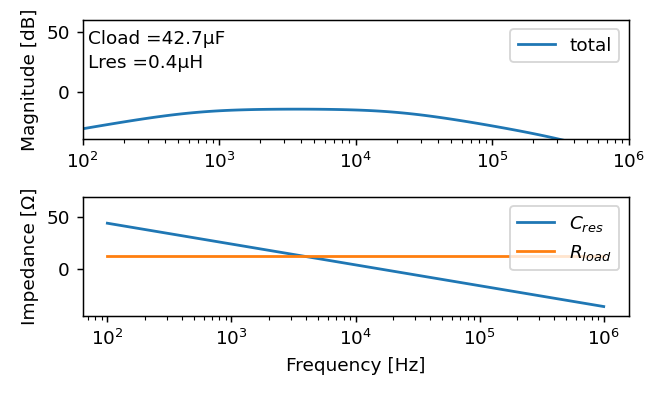

interactive(children=(FloatSlider(value=0.01, continuous_update=False, description='Rl_', max=10.0, min=0.01, …

In [9]:
%matplotlib notebook
#doesn't work with inline backend

max_Rl = 10
min_Rl = .01
max_Rd = 2
min_Rd = .01
max_Cres =40e-6
min_Cres = 1e-6
Rl_widget = FloatSlider(min=min_Rl, max=max_Rl, step=.02, readout_format='.3f', continuous_update=False)
Rd_widget = FloatSlider(min=min_Rd, max=max_Rd, step=.02, readout_format='.3f', continuous_update=False)
Cres_widget = FloatSlider(min=min_Cres, max=max_Cres, step=5e-6, readout_format='.1e', continuous_update=False)

fig, (ax, ax2) = plt.subplots( 2,1 , figsize=(5,3))
ax.set_ylim(bottom= -40, top=60)
ax.set_xlim(left=100, right=1e6)
ax.set_ylabel('Magnitude [dB]')
ax2.set_xlabel('Frequency [Hz]')
ax2.set_ylabel(f'Impedance [\u03A9]')

l, = ax.semilogx(freqs_f, mag(min_Rl, min_Rd, min_Cres), label='total')
l2, = ax2.semilogx(freqs_f, capmag(min_Cres), label=r'$C_{res}$')
l3, = ax2.semilogx(freqs_f, np.ones(100)*20*np.log10(min_Rl), label=r'$R_{load}$')
#l_approx, = ax.semilogx(freqs_f, low_q_mag(min_R, min_C), label='low Q')
ax.legend()
ax2.legend()
ax.annotate(f'Cload =?', (.01,.8), xycoords='axes fraction')
ax.annotate(f'Lres =?', (.01,.6),xycoords='axes fraction')
fig.tight_layout()

def update_annotation(Cres_, Rl_):
    def match(artist: Artist ):
        return type(artist) == matplotlib.text.Annotation
    t = ax.findobj(match=match)
    for text in t:
        if 'Cload' in text.get_text(): 
            text.set_text(f'Cload ={1e6/(2*np.pi*85e3*.01*Rl_):.1f}\u03BCF')
        elif 'Lres' in text.get_text(): 
            text.set_text(f'Lres ={1e6/((2*np.pi*85e3)**2*Cres_):.1f}\u03BCH')

def g(Rl_, Rd_, Cres_):
    l.set_ydata(mag(Rl_, Rd_, Cres_))
    l2.set_ydata(capmag(Cres_))
    l3.set_ydata(np.ones(100)*20*np.log10(Rl_))
    #l_approx.set_ydata(low_q_mag(Rd_, Cd_))
    update_annotation(Cres_, Rl_)
    fig.canvas.draw()

interactive_plot = interactive(g, Rl_ = Rl_widget, Rd_= Rd_widget, Cres_=Cres_widget)
interactive_plot

In [21]:
ax.get_children()

 Text(0.01, 0.8, 'Cload =18724.1μF'),
 Text(0.01, 0.6, 'Lres =?'),
 Text(0.5, 1.0, ''),
 Text(0.0, 1.0, ''),
 Text(1.0, 1.0, ''),

In [27]:
def clr_annotations(ax):
    for elem in ax._children: 
        if type(elem) == matplotlib.text.Annotation
        

list

In [31]:
type(ax._children[2]) == matplotlib.text.Annotation

True

In [23]:

def match(artist: Artist):
    return type(artist) == matplotlib.text.Annotation

In [24]:
ax.findobj(match=match)

[Text(0.01, 0.8, 'Cload =18724.1μF'), Text(0.01, 0.6, 'Lres =?')]

In [42]:
t = ax._children[2]
t.set_text('hi')
t.get_text()

'hi'

In [43]:
def update_annotation(C, L):
    def match(artist: Artist ):
        return type(artist) == matplotlib.text.Annotation
    t = ax.findobj(match=match)
    for text in t:
        if 'Cload' in text.get_text(): 
            t.set_text(f'Cload ={1e6/(2*np.pi*85e3*.01*Rl_):.1f}\u03BCF')
        elif 'Lres' in text.get_text(): 
            t.set_text(f'Lres ={1/((2*np.pi*85e3)**2*Cres_):.1f}\u03BCH')

In [34]:
import matplotlib
from matplotlib.artist import Artist